In [55]:
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.nam import NAM
from models.dnn import DNN
from models.utils import *

from config.default import defaults

from trainer.trainer import Trainer
from trainer.wandbtrainer import *

from data.toydataset import ToyDataset
from data.generator import *

from typing import Sequence 
from typing import List

import matplotlib.pyplot as plt 
import numpy as np

import wandb
"""
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [56]:
%reload_ext autoreload 
%autoreload 2

# Set up synthetic toy dataset 

tensor([[-0.4378,  0.7759,  0.9295],
        [-0.5173, -0.5167,  0.2099],
        [-0.6107,  0.3867,  0.4928],
        ...,
        [ 0.0077,  0.5419,  0.7373],
        [-0.6640, -0.0907,  0.1623],
        [-0.6862,  0.2393,  0.7403]])


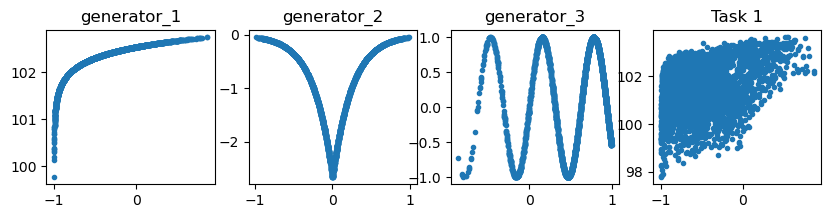

In [57]:
cfg = defaults()
gen_funcs, gen_func_names = task_0()

toydataset = ToyDataset(
    task_name="Task 1", 
    config=cfg, 
    num_samples=3000, 
    in_features=3, 
    x_start=-1, 
    x_end=1, 
    gen_funcs=gen_funcs, 
    gen_func_names=gen_func_names, 
    use_test=False,
)
print(toydataset.X)
toydataset.plot()

tensor([[-0.0760, -0.0760, -0.0760],
        [ 0.8024,  0.8024,  0.8024],
        [ 0.8930,  0.8930,  0.8930],
        ...,
        [-0.3348, -0.3348, -0.3348],
        [-0.3084, -0.3084, -0.3084],
        [ 0.2128,  0.2128,  0.2128]])


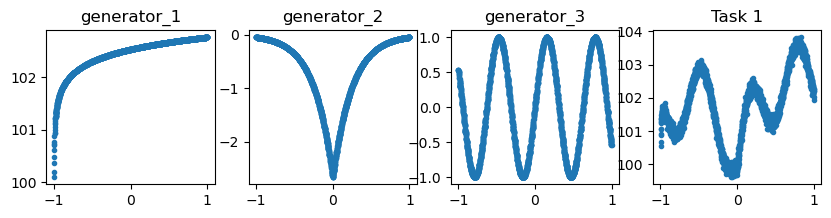

In [58]:
testdataset = ToyDataset(
    task_name="Task 1", 
    config=cfg, 
    num_samples=3000, 
    in_features=3, 
    x_start=-1, 
    x_end=1, 
    gen_funcs=gen_funcs, 
    gen_func_names=gen_func_names, 
    use_test=True,
)
print(testdataset.X)
testdataset.plot()

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xinyu-zhang. Use `wandb login --relogin` to force relogin


True

In [6]:
wandb.finish() # mark runs as finished before starting new runs

# W&B

In [7]:
# note that non-iterative type is invalid for wandb parameters_list
# note that log_uniform will add base exponents;
# while log_uniform_values expects specified values. 
parameters_list = {
    'lr': {
        'distribution': 'log_uniform_values',
        'min': 1e-3, 
        'max': 1e-1, 
    }, 
    'output_regularization': {
        'distribution': 'log_uniform_values',
        'min': 1e-3, 
        'max': 1e-1, 
    }, 
    'l2_regularization': {
        'distribution': 'log_uniform_values',
        'min': 1e-6, 
        'max': 1e-4, 
    }, 
    'dropout':  {
        'values': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }, 
    'feature_dropout': {
        'values': [0, 0.05, 0.1, 0.2]
    }, 
    'activation': {
        'values': ['exu', 'relu']
    }, 
    'decay_rate': {
        'values': [0, 0.05]
    }, 
    
}
sweep_configuration = {
    'method': 'bayes', 
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'val_MAE', 
    }, 
    'early_terminate': {
      'type': 'hyperband', 
        'min_iter': 3,
    },
    'parameters': parameters_list
}
# initialize the sweep 
sweep_id = wandb.sweep(
    sweep=sweep_configuration, 
    project='nam-sweep-3'
)

print(f"sweep id: {sweep_id}")

Create sweep with ID: 7orqu4je
Sweep URL: https://wandb.ai/xinyu-zhang/nam-sweep-3/sweeps/7orqu4je
sweep id: 7orqu4je


In [8]:
wandb.agent(sweep_id, 
            function=partial(sweep_train, config=cfg, dataset=toydataset),
            count=80) # specify the maximum number of runs

wandb: Agent Starting Run: o4aarj1b with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.2
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 2.7473845412902176e-05
wandb: 	lr: 0.007940837541614646
wandb: 	output_regularization: 0.08847120206606635
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.007940837541614646, l2_regularization=2.7473845412902176e-05, output_regularization=0.08847120206606635, dropout=0.2, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▁▆▄▇▆▁█▃▂▄▅▄▃▃▅▅▃▃▅▃▃▅▄▄▄▄▄▁▄▂▃▅▅▄▃▄▃▄▄▄
val_loss,▃▅▃▇▅▁█▂▂▃▄▃▂▂▄▄▂▂▃▂▂▄▃▃▃▂▃▁▃▁▂▃▃▂▂▂▁▃▂▃
epoch,99
train_MAE,21.05048
train_loss,736.87274
val_MAE,11.11484
val_loss,173.61636


wandb: Agent Starting Run: 9hjyoq2o with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 1.8096438516234905e-05
wandb: 	lr: 0.008265164878622569
wandb: 	output_regularization: 0.016718876627334303
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=20, lr=0.008265164878622569, l2_regularization=1.8096438516234905e-05, output_regularization=0.016718876627334303, dropout=0.1, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▇▇▆▅▄▄▆▄▇▅▇▃▇▆▄▄▇▇▅▅▆▁▅▁▃▅▅▄▅▃▅▄▅▄▆▄▅▄▃
val_loss,█▆▆▅▄▃▃▅▃▆▄▆▂▆▅▃▃▆▆▄▃▅▁▃▁▂▃▃▂▄▂▄▂▄▃▄▃▄▂▂
epoch,99
train_MAE,18.93721
train_loss,552.72833
val_MAE,4.62434
val_loss,34.0859


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rb8jmm51 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0
wandb: 	dropout: 0.7
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 3.034647417199726e-06
wandb: 	lr: 0.0022370979307196545
wandb: 	output_regularization: 0.037696825484363025
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0022370979307196545, l2_regularization=3.034647417199726e-06, output_regularization=0.037696825484363025, dropout=0.7, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁
val_MAE,█▄▃▃▃▄▂▃▃▂▂▂▂▂▃▃▃▂▃▁▂▁▂▂▂▁▂▁▁▁▂▂▂▂▁▁▂▂▁▂
val_loss,█▄▃▂▃▄▂▃▂▂▂▂▂▂▃▂▃▂▂▁▂▁▂▂▂▁▂▁▁▁▂▂▂▁▁▁▂▂▁▂
epoch,99
train_MAE,58.31772
train_loss,4515.05127
val_MAE,50.23584
val_loss,2533.51733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cp0r733q with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.2
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 9.346583546299982e-06
wandb: 	lr: 0.0019169664554796611
wandb: 	output_regularization: 0.08126505390545091
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0019169664554796611, l2_regularization=9.346583546299982e-06, output_regularization=0.08126505390545091, dropout=0.2, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,22.98087
train_loss,887.80896
val_MAE,9.28523
val_loss,157.72107


wandb: Agent Starting Run: j0dwqzzj with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 6.479801349866606e-05
wandb: 	lr: 0.0016942365325694649
wandb: 	output_regularization: 0.010402518296477472
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0016942365325694649, l2_regularization=6.479801349866606e-05, output_regularization=0.010402518296477472, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.68963
train_loss,12.61151
val_MAE,0.60166
val_loss,12.5651


wandb: Agent Starting Run: r3s127tc with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.4
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 3.452622062965462e-05
wandb: 	lr: 0.0060836076213595615
wandb: 	output_regularization: 0.06152103894451663
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0060836076213595615, l2_regularization=3.452622062965462e-05, output_regularization=0.06152103894451663, dropout=0.4, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_MAE,▄▆▇█▃▅▄▃▄▄▅▄▄▅▄▁▂▃▃▄▂▂▃▂▂▅▂▃▂▂▃▃▅▁▁▃▃▁▁▃
val_loss,▄▆▇█▃▅▄▃▄▄▄▄▄▄▄▁▂▃▂▄▂▂▃▂▂▄▂▃▂▁▂▂▄▁▁▃▃▁▁▂
epoch,99
train_MAE,31.84414
train_loss,1632.24329
val_MAE,21.59615
val_loss,494.3457


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z8b7isr5 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 3.624463422686039e-06
wandb: 	lr: 0.06157199011516876
wandb: 	output_regularization: 0.0023786254836002264
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.06157199011516876, l2_regularization=3.624463422686039e-06, output_regularization=0.0023786254836002264, dropout=0.05, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▄▁▁▃▅▂▄▂▄▂▂▆▂▁▁▂▁▁▃▁▁▃▂▂▂▂▂▂▃▃▁▃▁▁▁▂▁▁▁
val_loss,█▂▁▁▂▄▁▂▁▃▁▁▄▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁
epoch,99
train_MAE,6.59479
train_loss,85.15404
val_MAE,0.99867
val_loss,2.04548


wandb: Agent Starting Run: b568ozmt with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.5
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 7.203727629662379e-05
wandb: 	lr: 0.002323597638657889
wandb: 	output_regularization: 0.006006789364827256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.002323597638657889, l2_regularization=7.203727629662379e-05, output_regularization=0.006006789364827256, dropout=0.5, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,██▆▇▇▅▄▅▇▅▆▆▅▅▃▄▆▄▄▅▃▄▂▅▅▂▃▃▂▃▂▃▆▄▄▄▅▂▁▂
val_loss,█▆▄▆▅▄▃▄▆▄▄▄▄▄▃▃▄▃▃▄▃▃▂▄▄▂▃▂▂▃▂▂▅▃▃▃▄▂▁▂
epoch,99
train_MAE,42.26948
train_loss,2632.43872
val_MAE,27.66005
val_loss,769.73596


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xllaczwj with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 3.958328772493606e-06
wandb: 	lr: 0.06488197798417684
wandb: 	output_regularization: 0.005146742742851337
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.06488197798417684, l2_regularization=3.958328772493606e-06, output_regularization=0.005146742742851337, dropout=0.05, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▄▆▁▅▆▂▆▆▅█▅▂▄█▂▁▅▂▅▃▂▁▃▃▃▂▃▄▁▂▁▂▂▁▂▁▂▃▁▁
val_loss,▃▅▂▄▅▂▅▆▄█▄▂▃█▂▁▄▂▃▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▂▁▁
epoch,99
train_MAE,6.63725
train_loss,72.73782
val_MAE,1.10886
val_loss,2.6153


wandb: Agent Starting Run: d5bx8f4t with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 1.619310401236387e-05
wandb: 	lr: 0.01964241373446391
wandb: 	output_regularization: 0.007174897430418582
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.01964241373446391, l2_regularization=1.619310401236387e-05, output_regularization=0.007174897430418582, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▅▂▄▆▆▂▂▃▁▄▁▄▅▃▆▁▂▃▃▇█▂▂▇▅▂▃▃▃▄▄▃▂▄▄▃▅▁▄▁
val_loss,▄▁▃▅▅▂▂▂▁▃▁▃▄▂▅▁▂▂▂▇█▁▂▆▄▁▂▂▂▃▃▂▁▃▃▂▄▁▂▁
epoch,99
train_MAE,9.82717
train_loss,186.33891
val_MAE,0.94685
val_loss,5.44027


wandb: Agent Starting Run: we6inn6g with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 5.527603068053074e-05
wandb: 	lr: 0.04700586851273795
wandb: 	output_regularization: 0.01216676989816738
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.04700586851273795, l2_regularization=5.527603068053074e-05, output_regularization=0.01216676989816738, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▁▃▃▁▁▁▁▁▁▁▂▃▂▁▁▁▂
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
epoch,99
train_MAE,1.4681
train_loss,15.9126
val_MAE,1.77427
val_loss,16.3899


wandb: Agent Starting Run: p4widso1 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 2.015704250743223e-05
wandb: 	lr: 0.012304333161058684
wandb: 	output_regularization: 0.008510456901517489
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.012304333161058684, l2_regularization=2.015704250743223e-05, output_regularization=0.008510456901517489, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▃▄▃▅▂▁▃▃▄▄█▄▁▆▇▁▅▇▃▃▃▄▂▃▃▄▃▄▃▅▁▆▄▄▁▆▂▃▆
val_loss,█▂▃▂▃▂▁▂▂▃▃▇▃▁▅▆▁▄▆▂▂▂▃▂▂▂▃▂▃▂▃▁▅▃▂▁▄▁▂▄
epoch,99
train_MAE,10.53326
train_loss,225.89767
val_MAE,5.18783
val_loss,33.63745


wandb: Agent Starting Run: lw1nxtk5 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 1.478023972347588e-05
wandb: 	lr: 0.045131452749304794
wandb: 	output_regularization: 0.006753238267326113
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.045131452749304794, l2_regularization=1.478023972347588e-05, output_regularization=0.006753238267326113, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▆█▂▅▂▁▂▅▁▁▇▁▃▅▅▂▄▂▂▄▇▅▁▁▄▄▄▂▁▃▁▄▄▃▃▃▁▂▂▂
val_loss,▆█▂▄▂▁▂▄▁▁▇▁▂▄▄▂▂▁▁▂▆▄▁▁▂▃▂▁▁▂▁▃▂▂▂▂▁▁▁▁
epoch,99
train_MAE,6.72212
train_loss,91.10704
val_MAE,1.97304
val_loss,6.77955


wandb: Agent Starting Run: ykle36j4 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 1.1844289484308978e-05
wandb: 	lr: 0.02805395277317067
wandb: 	output_regularization: 0.004076947301432074
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.02805395277317067, l2_regularization=1.1844289484308978e-05, output_regularization=0.004076947301432074, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▂▁▁▁▁▁▂▂▂▁▂▁▂▂▁▂▁▂▁▁▁▃▂▂▃▁▁▂▂▁▃▁▁▂▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁
epoch,99
train_MAE,1.34821
train_loss,7.28827
val_MAE,0.87852
val_loss,5.7617


wandb: Agent Starting Run: 0fi8dm26 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 7.56147700644389e-05
wandb: 	lr: 0.00252782153527225
wandb: 	output_regularization: 0.005087134392297456
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.00252782153527225, l2_regularization=7.56147700644389e-05, output_regularization=0.005087134392297456, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.92772
train_loss,7.07594
val_MAE,0.89209
val_loss,6.94539


wandb: Agent Starting Run: uxs0x0rb with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 8.574258102729356e-06
wandb: 	lr: 0.03637724488381857
wandb: 	output_regularization: 0.00579536480441228
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.03637724488381857, l2_regularization=8.574258102729356e-06, output_regularization=0.00579536480441228, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▂▃▁▂▃▃▃▁▃▂▁▂▃▁▂▃▂▁▂▂▂▁▂▁▂▂▁▁▂▂▂▂▂▁▂▁▂
val_loss,█▁▁▁▂▁▁▂▂▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,7.85137
train_loss,121.20811
val_MAE,3.50999
val_loss,15.29274


wandb: Agent Starting Run: d306uho0 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 8.113606937554569e-05
wandb: 	lr: 0.047289305702247514
wandb: 	output_regularization: 0.004519885876355311
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.047289305702247514, l2_regularization=8.113606937554569e-05, output_regularization=0.004519885876355311, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▃▂▁▁▂▅▁▁▁▂▁▁▂▂▁▁▂▃▁▂
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,99
train_MAE,1.17271
train_loss,7.03712
val_MAE,1.77406
val_loss,9.24943


wandb: Agent Starting Run: em8yzagf with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 6.090578153712378e-05
wandb: 	lr: 0.028882832402566956
wandb: 	output_regularization: 0.003083709669385248
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=20, lr=0.028882832402566956, l2_regularization=6.090578153712378e-05, output_regularization=0.003083709669385248, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▁▂▃▁▆▁▃▅█▃▅▇▂▃▁▇▅▂▁▃▅▅▆▅▆▁▇▃▁▅▄▂▄▁▆▁▃▆▅▁
val_loss,▁▂▂▁▅▁▃▄█▂▄▆▂▂▁▇▃▂▁▂▄▄▅▄▅▁▆▂▁▄▂▂▃▁▅▁▂▅▃▁
epoch,99
train_MAE,7.15418
train_loss,107.29273
val_MAE,1.22352
val_loss,3.2918


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tteedwnp with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 2.1013268844960217e-05
wandb: 	lr: 0.030129139536799233
wandb: 	output_regularization: 0.017102282315069522
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.030129139536799233, l2_regularization=2.1013268844960217e-05, output_regularization=0.017102282315069522, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▄▄▁▆▂▆▅▂▄▃▅▁▄▂▂▂▂▁▃▁▂▁▃▁▁▃▂▂▂▁▄▄▁▁▁▃▂
val_loss,█▂▂▄▃▂▅▂▅▄▂▄▃▄▂▃▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▁▁▃▂▁▁▁▂▁
epoch,99
train_MAE,5.62853
train_loss,110.7768
val_MAE,1.37568
val_loss,12.81284


wandb: Agent Starting Run: rm6mhsug with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 5.768852190658149e-05
wandb: 	lr: 0.005144931709490901
wandb: 	output_regularization: 0.008313595983639724
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.005144931709490901, l2_regularization=5.768852190658149e-05, output_regularization=0.008313595983639724, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.77214
train_loss,10.36104
val_MAE,0.69559
val_loss,10.28454


wandb: Agent Starting Run: 3vzfaoxz with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 5.954968476402653e-05
wandb: 	lr: 0.04499496082984274
wandb: 	output_regularization: 0.008484928723000293
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=20, lr=0.04499496082984274, l2_regularization=5.954968476402653e-05, output_regularization=0.008484928723000293, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,1.23037
train_loss,11.06509
val_MAE,2.04714
val_loss,13.54164


wandb: Agent Starting Run: dhza3gxr with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 3.0296923705083165e-05
wandb: 	lr: 0.0028555328316857255
wandb: 	output_regularization: 0.024367966718282476
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0028555328316857255, l2_regularization=3.0296923705083165e-05, output_regularization=0.024367966718282476, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▄▂▂▄▂▃▂▁▁▂▃▄▁▅▄▁▂▂▁▁▅▁▄▃▁▃▃▄▃▂▄▁▃▃▄▃▃▁▂
val_loss,█▃▂▁▂▁▂▁▁▁▁▂▂▁▃▂▁▁▁▁▁▃▁▂▁▁▂▂▂▂▁▃▁▂▁▂▁▂▁▁
epoch,65
train_MAE,8.12749
train_loss,215.67473
val_MAE,2.47348
val_loss,33.33147


wandb: Agent Starting Run: 5v2ll1iw with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 1.8145227775462384e-05
wandb: 	lr: 0.014753303843178656
wandb: 	output_regularization: 0.0010415699413607287
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.014753303843178656, l2_regularization=1.8145227775462384e-05, output_regularization=0.0010415699413607287, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▂▁▂▁▁▃▁▂▁▁▁▁▃▁▁▁▁▁▄▁▂▃▁▁▁▁▂▂▂▁▃▁▁▂▁▃
val_loss,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂
epoch,99
train_MAE,6.69565
train_loss,133.96301
val_MAE,4.11705
val_loss,18.83715


wandb: Agent Starting Run: ns1qvv8i with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 6.15793803332848e-05
wandb: 	lr: 0.016048936729181194
wandb: 	output_regularization: 0.0023093138223009603
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.016048936729181194, l2_regularization=6.15793803332848e-05, output_regularization=0.0023093138223009603, dropout=0.05, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▃▃▃▃▃▂▂▂▅▃▁▄▃▂▄▂▄▂▃▂▃▂▂▂▂▂▃▁▃▁▃▂▁▂▂▃▂▁▁
val_loss,█▂▂▂▂▂▁▁▁▄▂▁▂▂▁▃▁▃▁▂▁▂▁▁▁▁▁▂▁▂▁▂▁▁▁▁▂▁▁▁
epoch,99
train_MAE,10.90206
train_loss,221.45842
val_MAE,1.22759
val_loss,3.8127


wandb: Agent Starting Run: vdw6cd09 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 4.150262427259308e-05
wandb: 	lr: 0.06966344608937977
wandb: 	output_regularization: 0.0024390701785344648
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.06966344608937977, l2_regularization=4.150262427259308e-05, output_regularization=0.0024390701785344648, dropout=0.1, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▂█▇▅▄▄▃▅▄▁▆▂▄▃▅▄▃▃▄▂▂▄▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂▁▁
val_loss,▂█▆▃▃▂▂▃▃▁▄▁▂▂▄▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,5.94924
train_loss,52.33418
val_MAE,1.85364
val_loss,4.85546


wandb: Agent Starting Run: b24uk4tu with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 3.2995297728409585e-05
wandb: 	lr: 0.0647950459061128
wandb: 	output_regularization: 0.005932068914425641
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0647950459061128, l2_regularization=3.2995297728409585e-05, output_regularization=0.005932068914425641, dropout=0.1, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▃▄▆▂▆▅▃▆▅▁▄▆▅▅▃▃▁▃▃▂▂▄▂▂▂▂▃▂▃▁▂▁▂▂▂▁▁▂▃
val_loss,█▂▂▅▂▅▃▂▅▃▁▂▅▃▃▂▂▁▂▂▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,6.10761
train_loss,64.85677
val_MAE,3.40914
val_loss,13.66308


wandb: Agent Starting Run: 4322n4g1 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 2.154981293014393e-05
wandb: 	lr: 0.07682795477486885
wandb: 	output_regularization: 0.005195875736201839
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.07682795477486885, l2_regularization=2.154981293014393e-05, output_regularization=0.005195875736201839, dropout=0.1, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▂▆▅▄██▇▃▁▄▃▃▄▂▄▃▃▂▃▃▃▂▂▂▂▁▁▂▄▁▂▂▁▁▂▁▃▁▁▂
val_loss,▂▅▄▃██▆▂▁▃▂▂▃▁▃▂▂▁▂▂▂▂▁▂▁▁▁▁▂▁▁▂▁▁▂▁▂▁▁▁
epoch,99
train_MAE,5.94163
train_loss,57.81496
val_MAE,1.76208
val_loss,5.01555


wandb: Agent Starting Run: bsrpnexy with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 8.75991318631326e-05
wandb: 	lr: 0.0034740864103404096
wandb: 	output_regularization: 0.002210245914973273
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0034740864103404096, l2_regularization=8.75991318631326e-05, output_regularization=0.002210245914973273, dropout=0.05, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▂▂▂▂▄▂▂▂▂▂▃▂▂▄▂▂▄▃▃▁▃▃▂▄▁▄▃▂▂▄▂▂▃▃▂▂▃▃▂
val_loss,█▁▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▃▂▁▁▂▂▁▂▁▂▂▁▁▃▁▁▂▂▁▁▂▂▁
epoch,99
train_MAE,13.23941
train_loss,330.94318
val_MAE,3.0874
val_loss,12.80275


wandb: Agent Starting Run: tr1btqau with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 9.732678429655202e-05
wandb: 	lr: 0.007019654782502482
wandb: 	output_regularization: 0.0011852261485670618
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.007019654782502482, l2_regularization=9.732678429655202e-05, output_regularization=0.0011852261485670618, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▂▁▁▂▁▁▃▁▂▁▂▁▁▂▁▁▂▁▃▁▁▁▂▁▂▁▁▂▃▁▂▁▂▂▁▂
val_loss,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch,99
train_MAE,6.9477
train_loss,161.35477
val_MAE,3.57525
val_loss,15.06874


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: shcsf8cn with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 3.910303051584289e-05
wandb: 	lr: 0.0188647650898389
wandb: 	output_regularization: 0.0019285832405555657
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0188647650898389, l2_regularization=3.910303051584289e-05, output_regularization=0.0019285832405555657, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▂
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.96244
train_loss,3.58216
val_MAE,1.54929
val_loss,5.54083


wandb: Agent Starting Run: 55pnghi1 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 5.0394087340627256e-05
wandb: 	lr: 0.02080157153615506
wandb: 	output_regularization: 0.002912923629709033
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.02080157153615506, l2_regularization=5.0394087340627256e-05, output_regularization=0.002912923629709033, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▂▁▁▂▂▁▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▅▂▄▅▅▂▃▅▁█▁▄▄▂▅▂▆▅▄▃▃█▄▁▂▅▂▇▂▂▆▁▂▃▂▁▂▄▅
val_loss,█▃▂▃▄▄▁▂▃▁▇▁▃▃▂▄▁▅▃▃▂▂▇▃▁▁▄▁▅▁▂▄▁▁▂▁▁▁▃▃
epoch,99
train_MAE,6.24045
train_loss,116.37891
val_MAE,3.45349
val_loss,14.99864


wandb: Agent Starting Run: 1usoz2in with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 3.138948721032524e-05
wandb: 	lr: 0.07827920572861234
wandb: 	output_regularization: 0.002097053652884553
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.07827920572861234, l2_regularization=3.138948721032524e-05, output_regularization=0.002097053652884553, dropout=0.1, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▂▄▁▁▆█▁▄▅▂▂▄▃▄▃▄▃▂▃▃▂▂▂▂▂▃▂▁▂▁▁▁▂▂▁▂▁▁▂▂
val_loss,▁▃▁▁▅█▁▂▄▁▁▃▂▃▂▃▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,6.21963
train_loss,64.3608
val_MAE,2.21116
val_loss,6.58216


wandb: Agent Starting Run: ew852l04 with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 6.966675066962883e-05
wandb: 	lr: 0.001754462799233834
wandb: 	output_regularization: 0.002521352311684568
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.001754462799233834, l2_regularization=6.966675066962883e-05, output_regularization=0.002521352311684568, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.9705
train_loss,4.31321
val_MAE,0.91448
val_loss,4.12803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gcit9pr3 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 1.6308697580074516e-05
wandb: 	lr: 0.03755920644221793
wandb: 	output_regularization: 0.0051445334687059575
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.03755920644221793, l2_regularization=1.6308697580074516e-05, output_regularization=0.0051445334687059575, dropout=0.05, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▄▄▂▇█▄▆▅▇▂▄▆▄▄▂▅▅▂▆▂▃▄▄▄▃▂▂▃▄▂▁▂▃▃▃▂▂▂▁▃
val_loss,▂▃▁▇█▂▅▄▆▁▂▅▂▃▂▄▃▁▄▁▂▃▂▃▂▁▁▂▂▁▁▁▂▂▂▁▁▁▁▂
epoch,99
train_MAE,8.63864
train_loss,120.32214
val_MAE,3.45121
val_loss,14.34191


wandb: Agent Starting Run: hte9te3t with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 7.389669269065833e-05
wandb: 	lr: 0.0020205279113850727
wandb: 	output_regularization: 0.0036039597255642505
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0020205279113850727, l2_regularization=7.389669269065833e-05, output_regularization=0.0036039597255642505, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.95718
train_loss,5.46033
val_MAE,0.92226
val_loss,5.33173


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8k20main with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 7.818606561623079e-05
wandb: 	lr: 0.028122541623855843
wandb: 	output_regularization: 0.004133095011214954
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.028122541623855843, l2_regularization=7.818606561623079e-05, output_regularization=0.004133095011214954, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▆▁▆▇▃▂▂▃▃▄▂▄▃▁▆▁▄▁▂▅▁▄▂▆▁▁▃▆▄▇▁▂▁▄▅▄▁▂▂
val_loss,█▅▂▅▆▂▂▂▂▂▃▂▃▂▁▅▁▃▁▂▄▁▃▂▅▁▁▂▄▂▆▁▁▁▃▃▂▁▁▁
epoch,99
train_MAE,6.09849
train_loss,110.89182
val_MAE,1.28077
val_loss,5.20403


wandb: Agent Starting Run: 9ecjyxxe with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 1.2170830751450228e-05
wandb: 	lr: 0.07846790405150324
wandb: 	output_regularization: 0.020539095124272183
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.07846790405150324, l2_regularization=1.2170830751450228e-05, output_regularization=0.020539095124272183, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▃▂▆▃▃▁▆▅█▆▂▂▇▂▄▄▃▁▁▂▃▅▇▄▅▂▄▁▁▂▄▃▄▃▄▁▃▁▃▂
val_loss,▄▄▆▄▄▃▆▅█▅▂▃▆▂▃▃▂▂▁▂▂▃▅▂▄▁▂▁▁▁▂▂▂▂▂▁▂▁▂▁
epoch,99
train_MAE,5.67347
train_loss,66.9854
val_MAE,1.60176
val_loss,7.37754


wandb: Agent Starting Run: 84a18nkl with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 1.5147025320087202e-05
wandb: 	lr: 0.0838591108987599
wandb: 	output_regularization: 0.009392195649949612
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0838591108987599, l2_regularization=1.5147025320087202e-05, output_regularization=0.009392195649949612, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▃▄▂▅▂▄▂▅▆▃▆▃▆▃█▃▁▂▂▂▂▁▂▂▁▂▃▁▂▂▂▁▂▁▁▁▁▁▁▁
val_loss,▄▄▃▅▃▄▂▅▆▃▆▃▅▃█▃▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,1.6933
train_loss,5.42596
val_MAE,0.88812
val_loss,1.31531


wandb: Agent Starting Run: u8786b4l with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 7.881233015733136e-05
wandb: 	lr: 0.005403493608269697
wandb: 	output_regularization: 0.0013820729406223036
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.005403493608269697, l2_regularization=7.881233015733136e-05, output_regularization=0.0013820729406223036, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▇▃▁▄▃▃▁▄▃▂▅▂▂█▁▁▅▇▄▁▁▂▆▃▂▁▄▇▃▃▁▁▇▆▁▄▄▁▂▁
val_loss,▇▂▁▃▂▂▁▃▂▁▄▁▁█▁▁▄▆▃▁▁▂▅▂▁▁▃▇▂▂▁▁▆▆▁▃▃▁▂▁
epoch,99
train_MAE,7.1077
train_loss,170.69545
val_MAE,0.99645
val_loss,2.90719


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 98j03wo8 with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 2.776775362098344e-05
wandb: 	lr: 0.002063840465047009
wandb: 	output_regularization: 0.0061578395059089745
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.002063840465047009, l2_regularization=2.776775362098344e-05, output_regularization=0.0061578395059089745, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.81771
train_loss,8.04117
val_MAE,0.76036
val_loss,7.91205


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vkhi2c22 with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 3.3360511561122184e-05
wandb: 	lr: 0.014673916442368332
wandb: 	output_regularization: 0.0019803446819421596
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.014673916442368332, l2_regularization=3.3360511561122184e-05, output_regularization=0.0019803446819421596, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▃▁▂▁▄▁▂▃▁▁▃▂▁▁▃▁▁▁▂▁▃▁
val_loss,█▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▂▁▁▂▂▁▁▂▁▁▁▂▁▂▁
epoch,99
train_MAE,0.78571
train_loss,3.20292
val_MAE,0.70865
val_loss,2.9787


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: itlrh370 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 4.433530253330324e-06
wandb: 	lr: 0.09285140416244536
wandb: 	output_regularization: 0.007147473500450144
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.09285140416244536, l2_regularization=4.433530253330324e-06, output_regularization=0.007147473500450144, dropout=0.1, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▆▂▆▆▁█▄▁▅▂▃▂▄▁▃▁▂▁▂▃▂▂▁▁▂▂▁▁▂▁▁▁▁▃▁▂▂▁▂▂
val_loss,▅▁▄▄▁█▃▁▄▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂
epoch,99
train_MAE,5.88532
train_loss,57.4688
val_MAE,3.57977
val_loss,14.7554


wandb: Agent Starting Run: 9vq3rfth with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 1.5570526679999562e-05
wandb: 	lr: 0.06728039580858072
wandb: 	output_regularization: 0.01067773942553927
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.06728039580858072, l2_regularization=1.5570526679999562e-05, output_regularization=0.01067773942553927, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▂▅▇▅█▂▂▄▁▂▁▁▂▃▁▁▂▄▁▂▂▁▃▃▂▁▁▁▃▁▁▂▁▁▂▁▁▁▂▁
val_loss,▂▄▆▄█▂▂▃▁▂▁▁▁▂▁▁▂▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,6.24597
train_loss,71.42751
val_MAE,1.30006
val_loss,4.63091


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0fw1q0vs with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 9.447329302029728e-05
wandb: 	lr: 0.0019155331330646256
wandb: 	output_regularization: 0.003780203653777574
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0019155331330646256, l2_regularization=9.447329302029728e-05, output_regularization=0.003780203653777574, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.86723
train_loss,5.45492
val_MAE,0.83823
val_loss,5.37627


wandb: Agent Starting Run: j651nwb8 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 2.3670256660424137e-05
wandb: 	lr: 0.061451088965597346
wandb: 	output_regularization: 0.004445037030936237
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.061451088965597346, l2_regularization=2.3670256660424137e-05, output_regularization=0.004445037030936237, dropout=0, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▇▄▄▄▇▃▄▃▃▇▅█▁▁▂▇▅▇▅▆▄▃▄▅▇▅▄▁▁▃▁▂▅▂▃▂▃▃▄▂
val_loss,▇▄▃▄▇▃▃▂▂▆▄█▁▁▂▆▄▆▄▅▃▂▃▄▆▄▃▁▁▂▁▁▄▁▂▁▂▂▃▁
epoch,99
train_MAE,6.32835
train_loss,75.05341
val_MAE,1.70442
val_loss,5.07009


wandb: Agent Starting Run: 3ew9a8to with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 5.220391210407674e-05
wandb: 	lr: 0.09994908853204948
wandb: 	output_regularization: 0.0021625451960199525
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.09994908853204948, l2_regularization=5.220391210407674e-05, output_regularization=0.0021625451960199525, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▅▁▂▄▆▆▆▆█▃▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▂▄▁▂▄▁▁▁▅▁▂▃▁
val_loss,▅▁▂▃▆▆▅▅█▃▁▁▂▁▂▁▁▁▁▁▃▁▁▁▁▁▁▂▃▁▁▄▁▁▁▄▁▂▂▁
epoch,99
train_MAE,1.02891
train_loss,4.0301
val_MAE,0.84027
val_loss,3.50781


wandb: Agent Starting Run: wexmml8d with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 3.629988295914133e-06
wandb: 	lr: 0.08243066770409539
wandb: 	output_regularization: 0.004775530938028512
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.08243066770409539, l2_regularization=3.629988295914133e-06, output_regularization=0.004775530938028512, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▇▄▆▇▄█▁▃▁▃▁▂▁▃▂▁▁▁▃▁▁▂▁▁▃▃▁▂▁▁▂▁▁▂▁▄▃▂▃▁
val_loss,▆▃▅▆▃█▁▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▂▁▂▁
epoch,99
train_MAE,4.96031
train_loss,72.95515
val_MAE,1.42111
val_loss,4.7226


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pwl3s23g with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 1.0617495066079968e-05
wandb: 	lr: 0.06675012713862433
wandb: 	output_regularization: 0.0010014158098852002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.06675012713862433, l2_regularization=1.0617495066079968e-05, output_regularization=0.0010014158098852002, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▂▄▄▁▂▂▄▃▁▂▂▂▁▂▁▄▂▂▃▂▁▁▂▂▂▃▁▁▂▁▂▁▁▁▂▂▂▂
val_loss,█▁▁▃▃▁▁▁▃▂▁▁▁▁▁▂▁▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,5.09451
train_loss,77.31123
val_MAE,1.83634
val_loss,4.91375


wandb: Agent Starting Run: k38tuxdc with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 5.2891522444195814e-05
wandb: 	lr: 0.001488582516639977
wandb: 	output_regularization: 0.003986903020720152
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.001488582516639977, l2_regularization=5.2891522444195814e-05, output_regularization=0.003986903020720152, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,8.84177
train_loss,209.65071
val_MAE,2.6623
val_loss,12.13028


wandb: Agent Starting Run: 42v7hllo with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 9.505455114422356e-05
wandb: 	lr: 0.0031296428155468364
wandb: 	output_regularization: 0.0015164364230326895
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0031296428155468364, l2_regularization=9.505455114422356e-05, output_regularization=0.0015164364230326895, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.88727
train_loss,2.87217
val_MAE,0.83501
val_loss,2.73256


wandb: Agent Starting Run: nsab1yqz with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 9.631242673428531e-05
wandb: 	lr: 0.08880421463604259
wandb: 	output_regularization: 0.028388205000563188
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.08880421463604259, l2_regularization=9.631242673428531e-05, output_regularization=0.028388205000563188, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▃▂▂▃▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▂▁▁▅▁█▆▄▄▁▅▁▂▇▃▁▂▁▄▂▄▂▂▂▄▄▃▂▂▃▁▂▃▄▁▂▂▁▁▁
val_loss,▃▃▃▅▃█▅▄▃▂▄▂▂▇▃▂▂▂▃▂▃▂▂▂▂▃▂▂▁▂▁▁▂▃▁▁▁▁▁▁
epoch,99
train_MAE,4.5589
train_loss,72.26916
val_MAE,1.1116
val_loss,11.67985


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: noump2by with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 4.340908467854536e-06
wandb: 	lr: 0.09937021201963624
wandb: 	output_regularization: 0.0037351216602636143
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.09937021201963624, l2_regularization=4.340908467854536e-06, output_regularization=0.0037351216602636143, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▃▆▁▃▁▇▁▁▂▃▆▁▂▂▂▁▁▁▂▁▁▂▁▃▄█▅▁▁▁▁▅▁▁▃▁▁▁▁▁
val_loss,▃▆▂▂▂▇▂▂▂▂▅▁▂▂▂▁▁▁▂▁▁▁▁▂▃█▄▁▁▁▁▄▁▁▂▁▁▁▁▁
epoch,99
train_MAE,4.81809
train_loss,71.08047
val_MAE,0.92188
val_loss,2.81474


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3nttr8s2 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 3.8236581620222915e-05
wandb: 	lr: 0.09985276267034214
wandb: 	output_regularization: 0.0036412390764975623
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.09985276267034214, l2_regularization=3.8236581620222915e-05, output_regularization=0.0036412390764975623, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▃▂▃▂▂▂▂▂▂▃▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▆▂▂▆▄▅▃▅▂▁█▂▂▂▄▄▁▂▂▁▃▁▁▃▁▄▄▂▃▁▃▁▁▂▂▂▁▁▂
val_loss,█▅▂▂▅▃▄▂▄▂▁█▂▁▁▃▂▁▁▁▁▂▁▁▂▁▃▃▁▂▁▂▁▁▁▁▂▁▁▁
epoch,99
train_MAE,4.68267
train_loss,64.65533
val_MAE,1.45378
val_loss,4.53086


wandb: Agent Starting Run: crcgkshv with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 3.5549611530626005e-05
wandb: 	lr: 0.05743651705641261
wandb: 	output_regularization: 0.009809424850796993
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.05743651705641261, l2_regularization=3.5549611530626005e-05, output_regularization=0.009809424850796993, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▅▂▂▇▁▅▁▂▂▄▁▁▃▄▄▂█▇▆▂▁▁▂▂▂▃▅▂▃▂▁▂▃▂▁▄▁▁▃▂
val_loss,▅▃▃█▂▄▂▂▂▄▂▂▃▃▃▂█▆▆▂▁▂▂▁▂▂▃▂▂▂▁▂▂▁▁▃▁▁▂▂
epoch,99
train_MAE,4.99601
train_loss,78.19057
val_MAE,2.01198
val_loss,9.54311


wandb: Agent Starting Run: immj6m52 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 1.0682083244493737e-05
wandb: 	lr: 0.04200683948743612
wandb: 	output_regularization: 0.004366776163644845
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.04200683948743612, l2_regularization=1.0682083244493737e-05, output_regularization=0.004366776163644845, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▁▂▁▁▃▁▃▅▂▂▁▁▆▂▁▃█▂▁▂▃▂▄▃▂▁▃▁▁▄▁▄▁▃▁▁▂▂▁▃
val_loss,▁▁▁▁▂▁▂▄▁▁▁▁▄▁▁▂█▁▁▂▂▂▃▂▂▁▂▁▁▃▁▂▁▂▁▁▁▁▁▂
epoch,99
train_MAE,5.53051
train_loss,91.35913
val_MAE,2.57586
val_loss,9.9726


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qxg2fkg6 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 2.8848947315475062e-05
wandb: 	lr: 0.04024286806022449
wandb: 	output_regularization: 0.002865907426141481
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.04024286806022449, l2_regularization=2.8848947315475062e-05, output_regularization=0.002865907426141481, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▁▁▄▁▁▂▁▁▂▃▁▁▁▁▁▁▂▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▃▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
epoch,99
train_MAE,1.13893
train_loss,5.14371
val_MAE,0.83082
val_loss,4.16841


wandb: Agent Starting Run: 0vbzg9z0 with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 1.753043503723301e-05
wandb: 	lr: 0.0027593080148096403
wandb: 	output_regularization: 0.00999273001006157
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0027593080148096403, l2_regularization=1.753043503723301e-05, output_regularization=0.00999273001006157, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.86448
train_loss,12.49652
val_MAE,0.86775
val_loss,12.427


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8zyw38jm with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 2.9286596784786655e-05
wandb: 	lr: 0.007861553404043911
wandb: 	output_regularization: 0.01263936369516892
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.007861553404043911, l2_regularization=2.9286596784786655e-05, output_regularization=0.01263936369516892, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▅▃▂▂▅█▁▃▅▁▄▅▃▂▃▆█▂▂▃▄▂█▃▃▄▅▂▅▄▃▅▁▂▁▁▅▂▂▃
val_loss,▅▃▂▂▄█▂▃▄▂▃▄▃▂▂▅█▂▂▂▃▂▇▂▂▃▄▂▄▃▂▄▁▁▁▁▄▁▁▂
epoch,99
train_MAE,7.76804
train_loss,176.84995
val_MAE,2.4493
val_loss,18.74396


wandb: Agent Starting Run: ngz17r2u with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 2.9007322643557035e-05
wandb: 	lr: 0.002568205018776513
wandb: 	output_regularization: 0.016664514721727714
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.002568205018776513, l2_regularization=2.9007322643557035e-05, output_regularization=0.016664514721727714, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▂▂▃▁▂▁▁▁▂▁▁▂▂▂▂▂▁▂▂▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,8.13143
train_loss,201.04358
val_MAE,1.27501
val_loss,20.14193


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o50ycqil with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 1.7778146181572907e-05
wandb: 	lr: 0.0033975984475730797
wandb: 	output_regularization: 0.005284066973300202
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0033975984475730797, l2_regularization=1.7778146181572907e-05, output_regularization=0.005284066973300202, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▂▁▂▂▂▂▂▁▁▁▁▂▂▁▁▂▂▁▂▂▁▁▁▁▂▁▁▂▁▁▁▂▁▁▂▂
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,7.72929
train_loss,172.52165
val_MAE,3.28061
val_loss,17.13518


wandb: Agent Starting Run: kuytsqkd with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 3.032009454078034e-05
wandb: 	lr: 0.004872259506250532
wandb: 	output_regularization: 0.004799913627543389
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.004872259506250532, l2_regularization=3.032009454078034e-05, output_regularization=0.004799913627543389, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.8279
train_loss,6.50809
val_MAE,0.73204
val_loss,6.34101


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: trn2vuh3 with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 4.763485490854986e-05
wandb: 	lr: 0.007374875848284248
wandb: 	output_regularization: 0.024257825010295716
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.007374875848284248, l2_regularization=4.763485490854986e-05, output_regularization=0.024257825010295716, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▅▇▂▄▃▃▅▅▂▄▇▆▃▂▁▂▄▁▁▃█▃▃▃▂▂▁▃▂▃▁▄▅▇▁▆▃▂▅
val_loss,█▃▅▂▃▂▂▃▃▂▃▅▄▂▂▁▂▂▁▁▂▅▂▂▂▁▁▁▂▁▂▁▂▃▄▁▃▂▁▃
epoch,99
train_MAE,7.54459
train_loss,179.14853
val_MAE,4.1326
val_loss,39.51788


wandb: Agent Starting Run: fdmowr4i with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 2.5790815105228717e-05
wandb: 	lr: 0.003416982736446343
wandb: 	output_regularization: 0.016366509322704753
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.003416982736446343, l2_regularization=2.5790815105228717e-05, output_regularization=0.016366509322704753, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.68046
train_loss,19.21317
val_MAE,0.58037
val_loss,19.02457


wandb: Agent Starting Run: xhsiu8fh with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 2.37472169036572e-05
wandb: 	lr: 0.05926558574644572
wandb: 	output_regularization: 0.012105608625429353
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.05926558574644572, l2_regularization=2.37472169036572e-05, output_regularization=0.012105608625429353, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▂▂▄▁▁▂▆▁█▆▃▁▂▁▂▆▃▃▄▆▂▂▄▄▄▁▂▂▂▁▁▁▂▂▂▁▁▅▂▁
val_loss,▂▂▄▂▂▂▅▂█▆▂▂▂▁▂▅▂▂▃▄▂▁▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁
epoch,99
train_MAE,4.64843
train_loss,73.12746
val_MAE,1.31261
val_loss,8.11092


wandb: Agent Starting Run: ifdrkupd with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 9.01769597017014e-06
wandb: 	lr: 0.005433021921088721
wandb: 	output_regularization: 0.0272791813776933
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.005433021921088721, l2_regularization=9.01769597017014e-06, output_regularization=0.0272791813776933, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.76045
train_loss,31.13798
val_MAE,0.64638
val_loss,31.07637


wandb: Agent Starting Run: 1cwwyaye with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 2.2309782664593104e-05
wandb: 	lr: 0.010267653044068842
wandb: 	output_regularization: 0.01477358659679796
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.010267653044068842, l2_regularization=2.2309782664593104e-05, output_regularization=0.01477358659679796, dropout=0.1, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▇▂▅█▄▄▁▁▃▄▂▄▅▄▁▁▁▂▂▄▆
val_loss,█▅▁▃▆▂▂▁▁▂▂▁▂▃▂▁▁▁▁▁▂▄
epoch,21
train_MAE,14.45516
train_loss,419.57367
val_MAE,5.69469
val_loss,49.02078


wandb: Agent Starting Run: wvt5g5sy with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 4.7932356461229465e-05
wandb: 	lr: 0.013201176608541544
wandb: 	output_regularization: 0.003291595721826067
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.013201176608541544, l2_regularization=4.7932356461229465e-05, output_regularization=0.003291595721826067, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.94773
train_loss,5.07459
val_MAE,0.89901
val_loss,4.85971


wandb: Agent Starting Run: fpa4lxjv with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 1.575509992824807e-05
wandb: 	lr: 0.06962749048215378
wandb: 	output_regularization: 0.0042884642949079545
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.06962749048215378, l2_regularization=1.575509992824807e-05, output_regularization=0.0042884642949079545, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▂▂▂▁▃▂▁▂▂▂▁▂▁▁▂▁▃▁▃▁▁▁▂▁▃▁▁▁▁▂▁▂▂▁▂▁▂▁▁
val_loss,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,5.50114
train_loss,87.29852
val_MAE,1.6922
val_loss,5.75819


wandb: Agent Starting Run: q1gmj74k with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 7.281107510798485e-05
wandb: 	lr: 0.0518903546022979
wandb: 	output_regularization: 0.009762054663342014
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0518903546022979, l2_regularization=7.281107510798485e-05, output_regularization=0.009762054663342014, dropout=0.05, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▅▆▁▁▄▄▅▂▁▁▃▄▁▂▄▄▂▃▂▂▁▁▂▂▃▁▂▁▁▁▂▂▂▁▂▁▁▂▂
val_loss,█▃▅▁▁▂▃▃▂▁▁▂▂▁▂▂▃▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,6.65825
train_loss,72.59631
val_MAE,2.70751
val_loss,10.01521


wandb: Agent Starting Run: 16pdyibt with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 2.1734608792827256e-05
wandb: 	lr: 0.028821463623818797
wandb: 	output_regularization: 0.011036063450024171
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.028821463623818797, l2_regularization=2.1734608792827256e-05, output_regularization=0.011036063450024171, dropout=0.05, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▄▄▄▄▃▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▁▃▄▁▃▃▃▄▅▂▄▁▅▃▁▃▂▄▂▃▂▃▃▁▁▂▂▂▃▂▄▃▂▂▂▂▂▂▂
val_loss,█▁▂▃▁▂▂▂▃▄▁▂▁▃▂▁▂▁▂▁▂▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
epoch,99
train_MAE,9.92404
train_loss,163.71222
val_MAE,3.22143
val_loss,14.91139


wandb: Agent Starting Run: tm3izcxn with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 4.340918210912524e-05
wandb: 	lr: 0.0033882919373328423
wandb: 	output_regularization: 0.0172280851101738
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.0033882919373328423, l2_regularization=4.340918210912524e-05, output_regularization=0.0172280851101738, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▂▂▁▁▂▁▂▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁▂▂▁▁▂▂▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,8.68128
train_loss,225.29048
val_MAE,3.01942
val_loss,27.84657


wandb: Agent Starting Run: axy5qqql with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 6.67596445575966e-05
wandb: 	lr: 0.05651639814193687
wandb: 	output_regularization: 0.0031873937601363147
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.05651639814193687, l2_regularization=6.67596445575966e-05, output_regularization=0.0031873937601363147, dropout=0.05, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▄▅▃▂▆▁▁▃▄█▅▇▄▆▃▅▃▃▄▁▁▃▁▂▃▃▂▂▃▂▁▁▂▃▁▁▁▂▂▂
val_loss,▃▄▂▂▅▁▁▂▃█▃▇▃▅▂▄▂▂▃▁▁▂▁▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂
epoch,99
train_MAE,5.96869
train_loss,74.27603
val_MAE,2.43572
val_loss,8.2264


wandb: Agent Starting Run: zdlzq9si with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.2
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 2.4116041453470933e-05
wandb: 	lr: 0.08950475282657575
wandb: 	output_regularization: 0.0044434125880665
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.08950475282657575, l2_regularization=2.4116041453470933e-05, output_regularization=0.0044434125880665, dropout=0.2, feature_dropout=0.1, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▂▇▂▆██▇▄▆▄▇▆▅▄▃▃▂▂▃▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁
val_loss,▁▆▂▅▇█▇▃▅▃▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,5.12887
train_loss,39.66462
val_MAE,2.50433
val_loss,7.75009


wandb: Agent Starting Run: 5668otyy with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 1.997387520796099e-05
wandb: 	lr: 0.07015516923632295
wandb: 	output_regularization: 0.009421551919037171
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.07015516923632295, l2_regularization=1.997387520796099e-05, output_regularization=0.009421551919037171, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▅▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁█▁▁▂▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁
val_loss,▃▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,1.40714
train_loss,12.84363
val_MAE,0.79329
val_loss,10.93871


wandb: Agent Starting Run: 6z7prh6h with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 2.668399901638996e-05
wandb: 	lr: 0.004454557665779464
wandb: 	output_regularization: 0.0010169405252961298
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.004454557665779464, l2_regularization=2.668399901638996e-05, output_regularization=0.0010169405252961298, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▄▃▃▄▃▃▃▄▆▁▃▁▁▃▆▅▁▆▂▁▂▅▁▃▃▄▄▃▁▂▁▂▄▂█▂▅▆▄▃
val_loss,▄▂▂▃▂▂▂▃▄▁▂▁▁▂▅▄▁▅▁▁▂▄▁▂▂▃▃▂▁▁▁▁▃▁█▁▄▅▃▂
epoch,99
train_MAE,8.57265
train_loss,188.57036
val_MAE,2.20542
val_loss,6.99552


wandb: Agent Starting Run: rwys5813 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 3.888287869434899e-05
wandb: 	lr: 0.06038511274886605
wandb: 	output_regularization: 0.005959890176391647
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.06038511274886605, l2_regularization=3.888287869434899e-05, output_regularization=0.005959890176391647, dropout=0, feature_dropout=0.2, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▄█▃▄▄▅▄▃▄▄▂▃▅▂▃▃▂▂▃▂▂▂▂▂▂▁▂▁▂▃▁▁▂▂▁▁▁▁▁▁
val_loss,▂█▂▂▃▃▃▂▃▃▁▂▃▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,6.17475
train_loss,57.98534
val_MAE,2.55474
val_loss,8.36189


wandb: Agent Starting Run: jssnhm1k with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 4.3489604443061056e-05
wandb: 	lr: 0.003536573007796239
wandb: 	output_regularization: 0.012317955535556414
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.003536573007796239, l2_regularization=4.3489604443061056e-05, output_regularization=0.012317955535556414, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,0.80477
train_loss,14.94784
val_MAE,0.70916
val_loss,14.87078


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4tsh9e6i with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0
wandb: 	l2_regularization: 6.9466894414234e-05
wandb: 	lr: 0.030342470440745124
wandb: 	output_regularization: 0.002063031407588634
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.030342470440745124, l2_regularization=6.9466894414234e-05, output_regularization=0.002063031407588634, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,▇▂▁▁▁▁▁▁▁▁▁▁▂▂▄▁▁▁▁▁▁▂▆▃▅▅█▂▁▃▅▅▁▃▄▂▂▂▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▂▂▃▁▁▁▁▁▁▂▅▃▄▅█▁▁▃▄▅▁▂▃▁▂▂▁▁
epoch,99
train_MAE,1.29654
train_loss,4.84765
val_MAE,0.82774
val_loss,3.33259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lqkp8vd4 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 1.9720250749917467e-05
wandb: 	lr: 0.02669496099285553
wandb: 	output_regularization: 0.00414464124917117
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.02669496099285553, l2_regularization=1.9720250749917467e-05, output_regularization=0.00414464124917117, dropout=0, feature_dropout=0.2, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▇▁▆█▃▆▇▅▇▃▆▃▆▄▆▁▃▄▄▄▅▃▂▆▅▂▃▅▂▄▄▃▅▅▅▄▃▂▃
val_loss,█▆▁▅█▂▅▆▄▆▂▄▂▅▃▄▁▂▂▃▂▄▂▁▅▃▁▂▃▁▃▂▂▃▃▃▂▂▁▂
epoch,99
train_MAE,11.73595
train_loss,201.5741
val_MAE,3.56154
val_loss,14.98923


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d3gt4jub with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.05
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 6.481377457246216e-06
wandb: 	lr: 0.07088587088134235
wandb: 	output_regularization: 0.002868215265921762
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Config(regression=True, use_dnn=False, num_epochs=100, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.07088587088134235, l2_regularization=6.481377457246216e-06, output_regularization=0.002868215265921762, dropout=0, feature_dropout=0.05, num_basis_functions=64, hidden_sizes=[64, 32], activation='relu')
Finished Training.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_MAE,█▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAE,█▅▄▂▁▄▂▃▃▃▆▃▄▄▄▆▁▁▁▂▃▁▂▂▆▃▃▁▁▂▂▁▁▁▁▁▂▂▁▂
val_loss,█▄▃▁▁▃▂▂▂▂▅▂▃▃▃▅▁▁▁▁▂▁▁▁▅▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,99
train_MAE,4.91283
train_loss,69.99631
val_MAE,1.50436
val_loss,4.33074


loss_train_epoch: 4.583789348602295, MAE_train_epoch: 1.6736047972332349
loss_val_epoch: 1.5610322952270508, MAE_val_epoch: 0.9644544959068299
loss_train_epoch: 1.4324978590011597, MAE_train_epoch: 0.9796659549077352
loss_val_epoch: 1.4011653661727905, MAE_val_epoch: 0.9687153100967407
loss_train_epoch: 1.3724225759506226, MAE_train_epoch: 0.9491231947234182
loss_val_epoch: 1.3784008026123047, MAE_val_epoch: 0.9608774423599243
loss_train_epoch: 1.351552963256836, MAE_train_epoch: 0.9363566438357035
loss_val_epoch: 1.3718254566192627, MAE_val_epoch: 0.9250935316085815
loss_train_epoch: 1.3294436931610107, MAE_train_epoch: 0.932121273243066
loss_val_epoch: 1.327742576599121, MAE_val_epoch: 0.9159377217292786
loss_train_epoch: 0.94081711769104, MAE_train_epoch: 0.7797176693425034
loss_val_epoch: 1.0838240385055542, MAE_val_epoch: 0.8582177042961121
loss_train_epoch: 0.8993631601333618, MAE_train_epoch: 0.7664856567527308
loss_val_epoch: 0.9803475141525269, MAE_val_epoch: 0.810888206958770

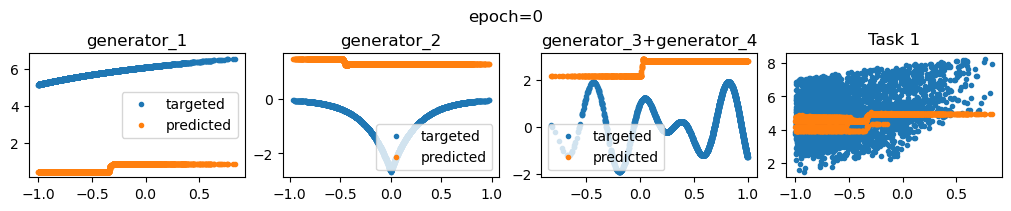

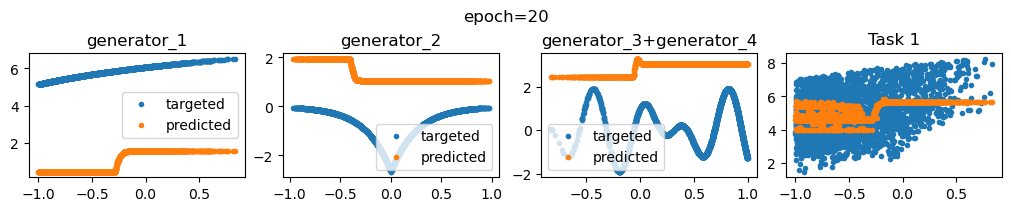

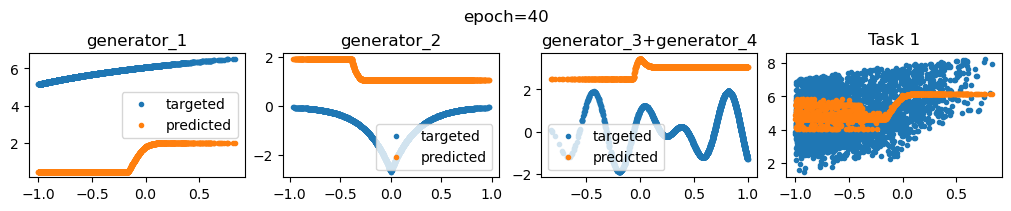

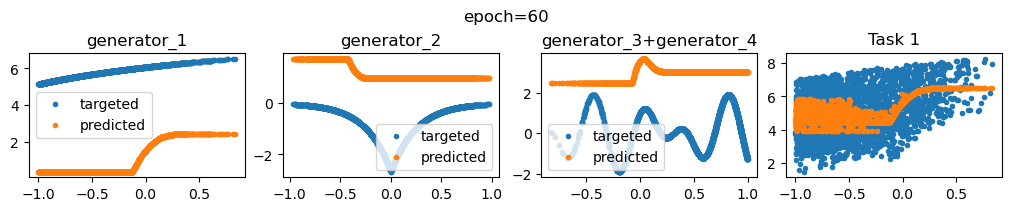

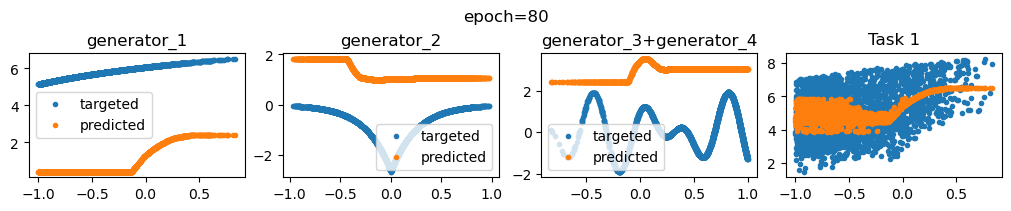

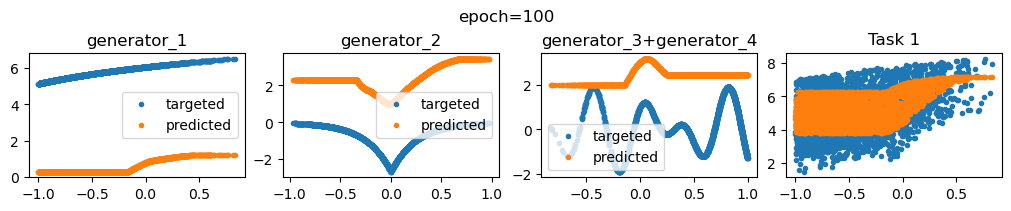

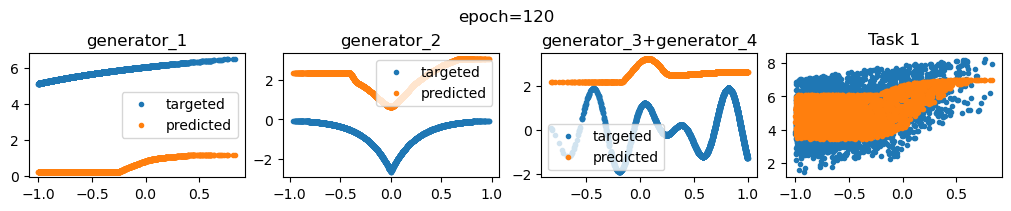

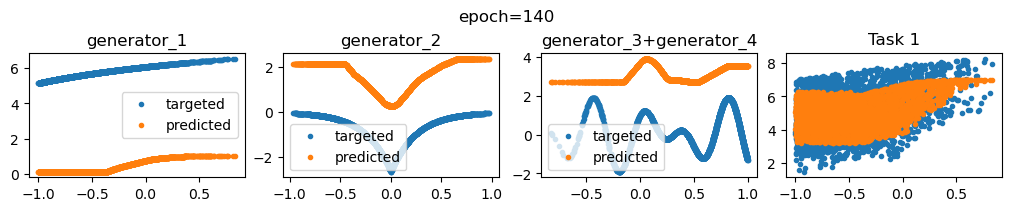

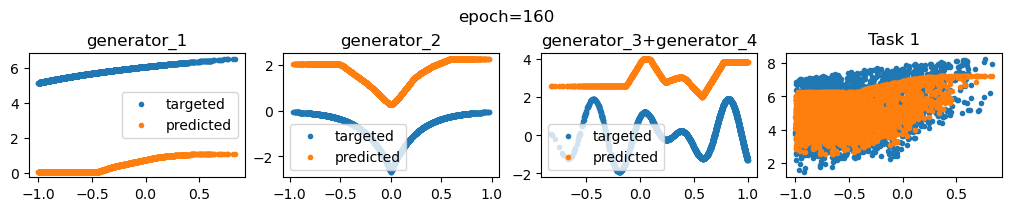

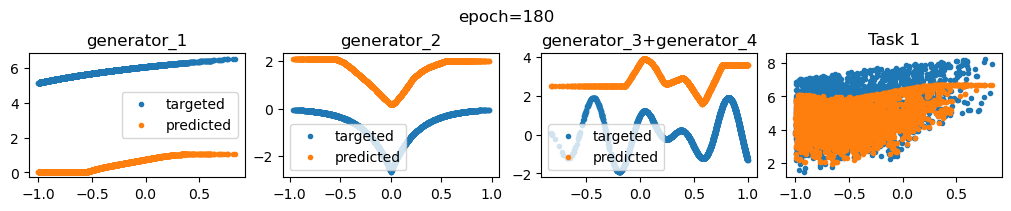

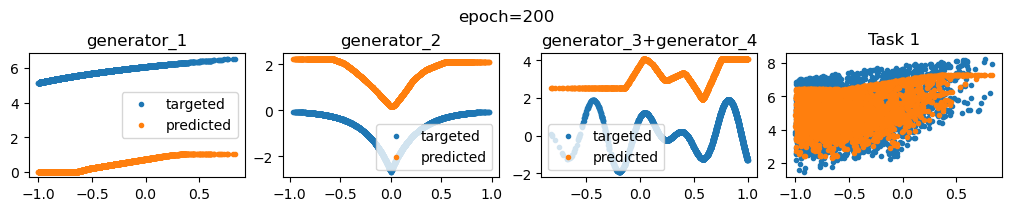

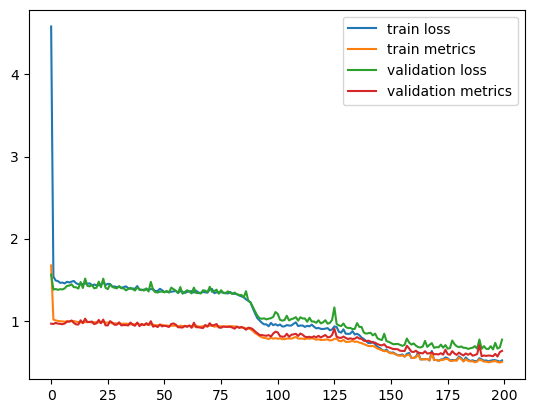

In [12]:
losses_train, metricses_train, losses_val, metricses_val = trainer.train()

In [59]:
cfg = defaults()
cfg.activation = 'exu'
cfg.decay_rate = 0.05
cfg.l2_regularization = 0.00002579081510522872
cfg.lr = 0.003416982736446343
cfg.output_regularization = 0.016366509322704753
cfg.num_epochs = 200
model = NAM(
    config=cfg, 
    name="NAM_BEST", 
    in_features=len(toydataset[0][0]), 
    num_units=cfg.num_basis_functions)
print(model)
trainer_best = Trainer(cfg, model, toydataset)   
print(cfg)

NAM(
  (feature_dropout): Dropout(p=0, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=64)
        (1): Dropout(p=0, inplace=False)
        (2): LinearReLU(in_features=64, out_features=64)
        (3): Dropout(p=0, inplace=False)
        (4): LinearReLU(in_features=64, out_features=32)
        (5): Dropout(p=0, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
        (7): Dropout(p=0, inplace=False)
      )
    )
  )
)
Config(regression=True, use_dnn=False, num_epochs=200, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.05, logdir='output', wandb=False, log_loss_frequency=20, lr=0.003416982736446343, l2_regularization=2.579081510522872e-05, output_regularization=0.016366509322704753, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')


loss_train_epoch: 4347.1962890625, MAE_train_epoch: 57.14566086277817
loss_val_epoch: 557.5377197265625, MAE_val_epoch: 22.158623123168944
loss_train_epoch: 19.83757972717285, MAE_train_epoch: 0.8967130129987543
loss_val_epoch: 19.831514358520508, MAE_val_epoch: 0.9348123788833618
loss_train_epoch: 19.435617446899414, MAE_train_epoch: 0.7582126422361894
loss_val_epoch: 19.366907119750977, MAE_val_epoch: 0.7562556266784668
loss_train_epoch: 19.080820083618164, MAE_train_epoch: 0.5955184481360696
loss_val_epoch: 19.221843719482422, MAE_val_epoch: 0.7649181962013245
loss_train_epoch: 19.03009033203125, MAE_train_epoch: 0.5847963257269426
loss_val_epoch: 19.022836685180664, MAE_val_epoch: 0.55325927734375
loss_train_epoch: 18.99803924560547, MAE_train_epoch: 0.5974214618856256
loss_val_epoch: 18.98980712890625, MAE_val_epoch: 0.647333812713623
loss_train_epoch: 18.971397399902344, MAE_train_epoch: 0.6143798557194796
loss_val_epoch: 19.11686134338379, MAE_val_epoch: 0.5992073535919189
loss_

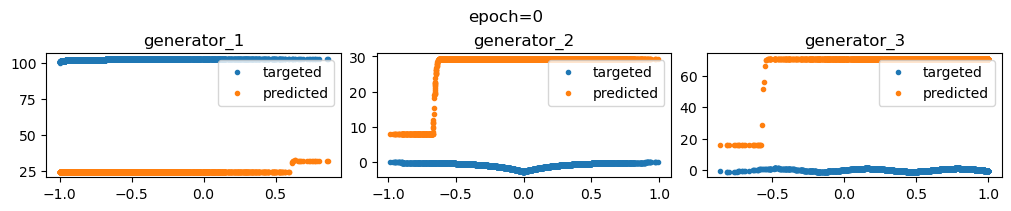

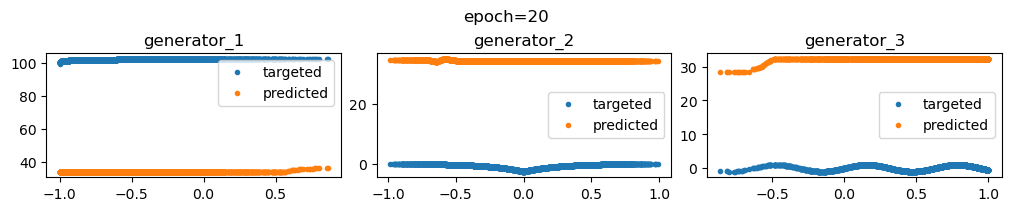

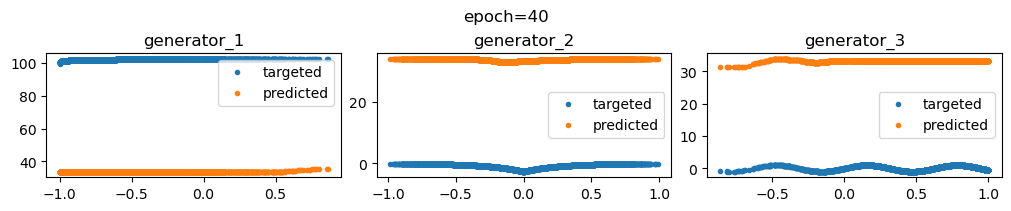

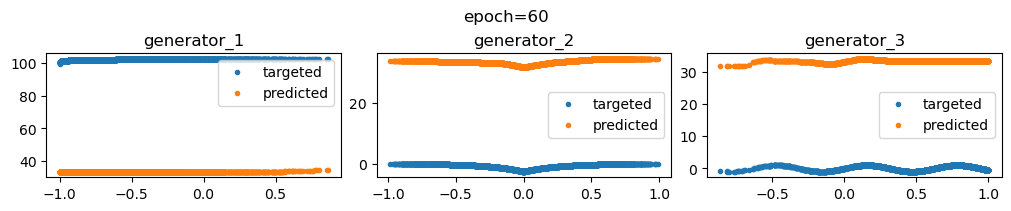

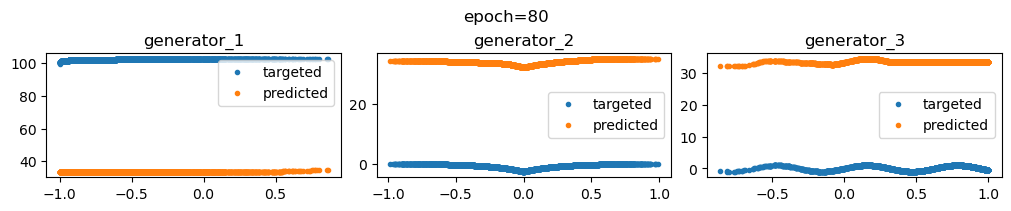

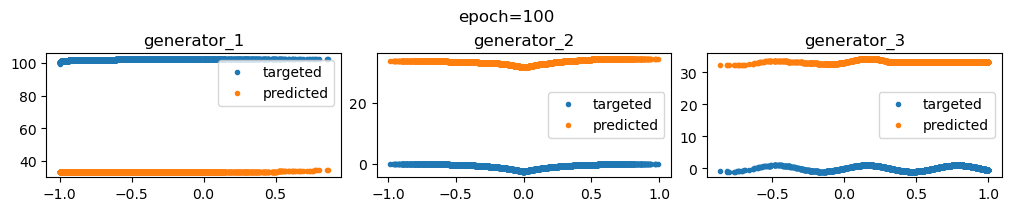

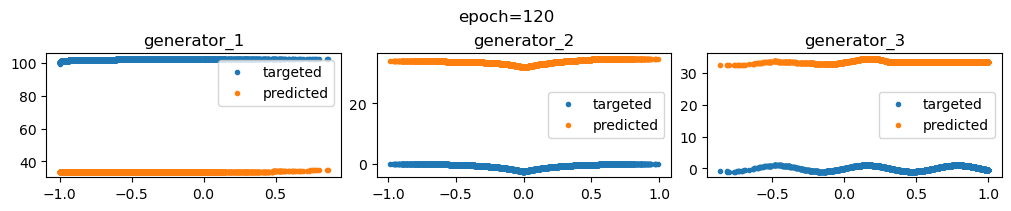

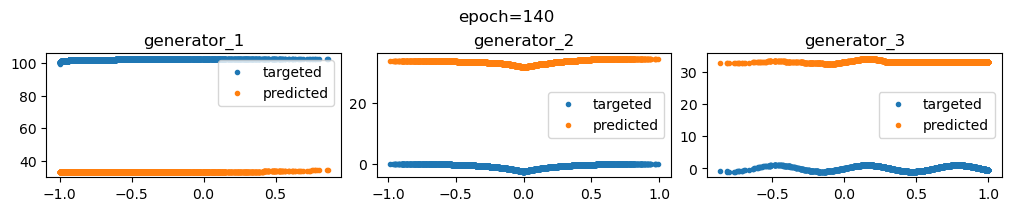

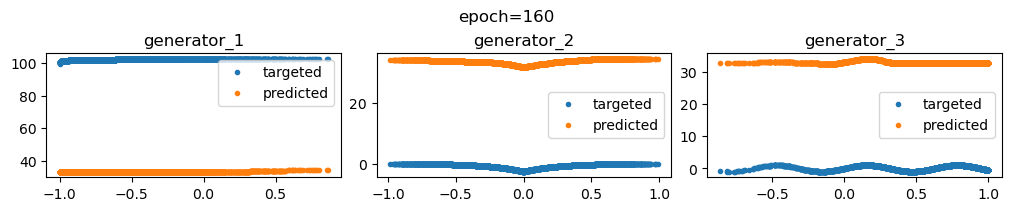

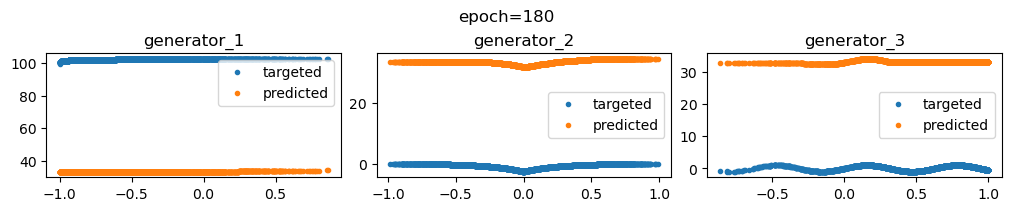

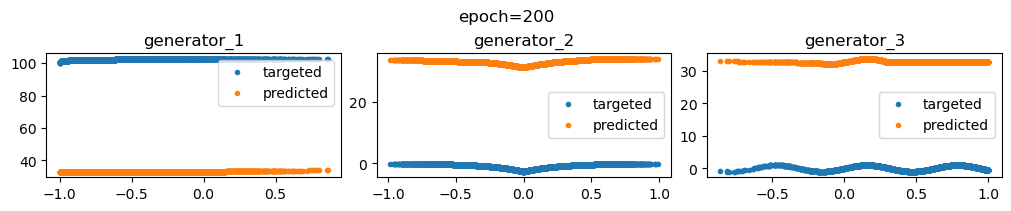

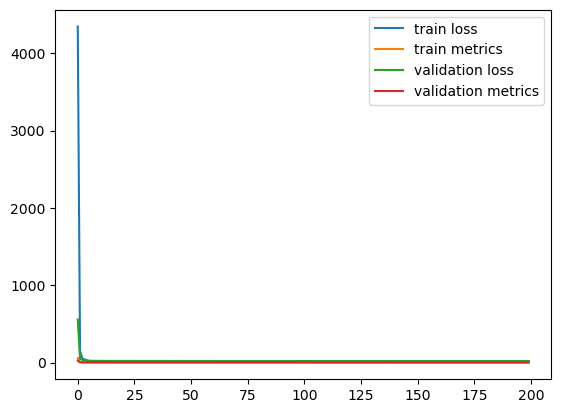

In [60]:
losses_train, metricses_train, losses_val, metricses_val = trainer_best.train()

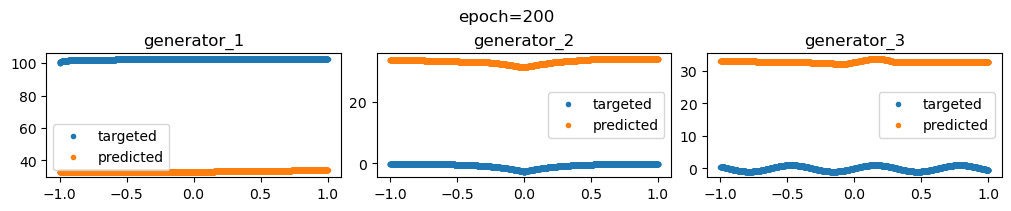

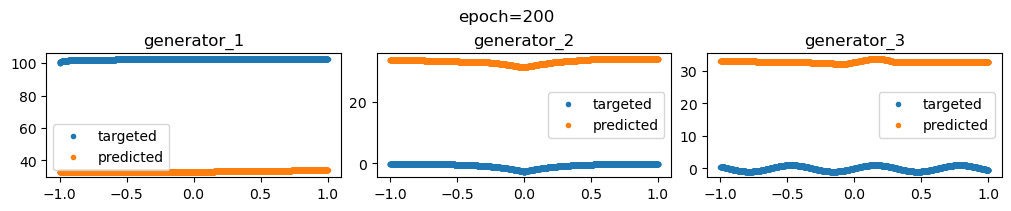

In [61]:
plot_preds(testdataset, model, cfg.num_epochs)